In [1]:
import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import random
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_linalg_ops
from tensorflow.python.ops import linalg_ops
from tensorflow.python.ops import math_ops

In [2]:
def logdet(matrix, name=None):
  """Computes log of the determinant of a hermitian positive definite matrix.
  ```python
  # Compute the determinant of a matrix while reducing the chance of over- or
  underflow:
  A = ... # shape 10 x 10
  det = tf.exp(tf.logdet(A))  # scalar
  ```
  Args:
    matrix:  A `Tensor`. Must be `float32`, `float64`, `complex64`, or
      `complex128` with shape `[..., M, M]`.
    name:  A name to give this `Op`.  Defaults to `logdet`.
  Returns:
    The natural log of the determinant of `matrix`.
  @compatibility(numpy)
  Equivalent to numpy.linalg.slogdet, although no sign is returned since only
  hermitian positive definite matrices are supported.
  @end_compatibility
  """
  # This uses the property that the log det(A) = 2*sum(log(real(diag(C))))
  # where C is the cholesky decomposition of A.
  with ops.name_scope(name, 'logdet', [matrix]):
    chol = gen_linalg_ops.cholesky(matrix)
    return 2.0 * math_ops.reduce_sum(
        math_ops.log(math_ops.real(array_ops.matrix_diag_part(chol))[::-1]),
        reduction_indices=[-1])

In [3]:
def get_gaussian_tuning(x, mu, sigma):
    #norm = 1.0/math.sqrt(2*math.pi*(sigma**2))
    norm = 1.0
    exponent = -((x-mu)**2)/(2*(sigma**2))
    tuning = norm*np.exp(exponent)
    return tuning

In [4]:
def get_onehot_tuning(x, mu, half_width):
    tuning = 0
    distance = abs(x-mu)
    if distance<half_width:
        tuning = 1
    else:
        tuning = 0
    return tuning

In [5]:
def generate_data(N,num_features,num_labels,angle_range,allow_wrapping,sigma=22,tuning_curves='gaussian'):
    degs = angle_range*np.random.rand(N, 1) # random angles between 0 and angle_range degrees

    training_feat = np.zeros((N, num_features)) #tuning curve values
    labels = np.zeros((N,num_labels))
    label_degs = np.linspace(0,angle_range*(1.0-1.0/num_labels),num_labels)
    tuning_mus = np.zeros(num_features)
    angle_distance = angle_range/num_features
    half_width = angle_distance/2.0
    #future edit: add option for cos^2((theta-theta_0)/2) or Hamming curve
    for i in range(N):
        x_val = degs[i]
        start_mu = 0
        tune_num = 0   
        if tuning_curves == 'gaussian':
            while start_mu < angle_range:
                if start_mu == 0:
                    if allow_wrapping:
                        if abs(x_val-0) < abs(x_val-360):
                            x_tune = get_gaussian_tuning(x_val,0,sigma)
                        else:
                            x_tune = get_gaussian_tuning(x_val,360,sigma)    
                    else:
                        x_tune = get_gaussian_tuning(x_val,0,sigma)
                else:
                    x_tune = get_gaussian_tuning(x_val,start_mu,sigma)
                training_feat[i,tune_num] = x_tune
                if i ==0:
                    tuning_mus[tune_num]=start_mu
                tune_num+=1
                start_mu+=angle_distance
            

        elif tuning_curves == 'one-hot':        
            while start_mu < angle_range:
                if start_mu == 0:
                    if allow_wrapping:
                        if abs(x_val-0) < abs(x_val-360):
                            x_tune = get_onehot_tuning(x_val,0,half_width)
                        else:
                            x_tune = get_onehot_tuning(x_val,360,half_width)    
                    else:
                        x_tune = get_onehot_tuning(x_val,0,half_width)
                else:
                    x_tune = get_onehot_tuning(x_val,start_mu,half_width)
                training_feat[i,tune_num] = x_tune
                if i ==0:
                    tuning_mus[tune_num]=start_mu            
                tune_num+=1
                start_mu+=angle_distance

    
    
    # Label is direction with lowest distance from degree
    
        if allow_wrapping:
            if abs(x_val-0) < abs(x_val-360):
                label_degs[0] = 0
            else:
                label_degs[0] = 360      
    
        distances = abs(label_degs - x_val)
        min_dist_ind = np.where(distances==np.amin(distances))[0][0]
        labels[i,min_dist_ind] = 1
    return training_feat, labels, tuning_mus

In [6]:
# Set model and data parameters
N = 600000
noise_gen_scale = 0.1

tuning_curves = 'gaussian'
allow_wrapping = True
num_features = 8
num_labels = 4
sigma = 22
angle_range = 360.0


In [7]:
training_feat, labels, tuning_mus = generate_data(N,num_features,num_labels,angle_range,allow_wrapping,sigma=22,tuning_curves='gaussian')

In [8]:
N_test = 10000

In [9]:
test_feat, labels_test, tuning_mus_test = generate_data(N_test,num_features,num_labels,angle_range,allow_wrapping,sigma=22,tuning_curves='gaussian')
eps_test = np.random.normal(size = (N_test, num_features),scale = noise_gen_scale)

In [ ]:
# Plot basis functions
degs = np.linspace(0, angle_range,num = angle_range*10)
x_vals = degs
angle_distance = angle_range/num_features
half_width = angle_distance/2.0
for i in range(num_features):
    mu = i*angle_distance
    if allow_wrapping:
        if mu ==0:
            diff0 = abs(degs)
            diff360 = abs(degs-angle_range)
            x_vals[np.where(sp.greater_equal(diff0,diff360))[0][0]] = diff360[np.where(sp.greater_equal(diff0,diff360))[0][0]]
            x_vals[np.where(sp.less(diff0,diff360))[0][0]] = diff0[np.where(sp.less(diff0,diff360))[0][0]]                                                         
        else:
            x_vals = degs
    basis_val = get_gaussian_tuning(x_vals,mu,half_width)
    plt.scatter(degs,basis_val)
plt.show()

In [ ]:
print(degs)
print(x_vals)

In [10]:
sess = tf.InteractiveSession()

In [11]:
# Define inputs and trainable variables in graph
x = tf.placeholder(tf.float32, shape = [None, num_features], name = 'x')
y_ = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y')
eps = tf.placeholder(tf.float32, [None, num_features])
#W = tf.Variable(tf.random_normal([num_features, num_labels]))
# Try initializing weights to identity
#W = tf.Variable(tf.eye(num_features, num_labels))
W = tf.Variable(tf.zeros([num_features, num_labels]))

#b = tf.Variable(tf.random_normal([num_labels]))
b = tf.Variable(tf.zeros([num_labels]))
# Start with constant A:
#A = tf.constant(np.random.normal(size = [num_features, num_features]),dtype=tf.float32) # Trainable noise parameters
# For trainable A:
A = tf.Variable(tf.random_normal([num_features, num_features]))

In [12]:
# Introduce noise to the system in a trainable way
scale = tf.constant(1.)
cov = scale * tf.eye(num_features) + tf.matmul(A, A, transpose_b = True)
cov_normalized = cov/tf.pow(tf.matrix_determinant(cov), 1./num_features)
L = tf.cholesky(cov_normalized)
noise = tf.matmul(eps, L, transpose_b = True)

In [13]:
noise_scale = tf.constant(1.) #
y_0 = tf.matmul(noise_scale*x + noise, W) + b
#No noise:
#y_0 = tf.matmul(x, W) + b
y = y_0
noise_log_det = logdet(cov)
nld_scale = tf.constant(10.)
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y)
)
cost = cross_entropy 
#+ nld_scale*noise_log_det

In [14]:
# Define accuracy value in graph
correct_predictions = tf.equal(tf.argmax(y, axis = 1), tf.argmax(y_, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
noise_logdetA = logdet(A)

In [15]:
learn_rate = 0.01
momentum = 0.8
train_step = tf.train.MomentumOptimizer(learn_rate,momentum).minimize(cost)

In [16]:
sess.run(tf.global_variables_initializer())

In [33]:
batch_size = 100
num_trials = 1000

In [34]:
accuracy_log = np.zeros(num_trials)
cost_log = np.zeros(num_trials)
for trial in range(num_trials):
    idx = random.sample(range(0,N),batch_size)
    x_batch = training_feat[idx, :]
    y_batch = labels[idx, :]
    ld_cov = logdet(cov)
    ld_cov_norm = logdet(cov_normalized)
    eps_in = np.random.normal(size = (batch_size, num_features),scale = noise_gen_scale)
    #eps_in  = np.zeros([batch_size, num_features])
    print(trial)
    if trial > 0:
        print(cost_val)
        print(accuracy_val)
    
    train_step.run(feed_dict= {x : x_batch, y_ : y_batch, eps : eps_in})
    cost_val = sess.run(cost,feed_dict={x : x_batch, y_ : y_batch, eps : eps_in})
    accuracy_val = sess.run(accuracy,feed_dict= {x : test_feat, y_ : labels_test, eps : eps_test})
    accuracy_log[trial]=accuracy_val
    cost_log[trial]=cost_val
    

0
1
0.230624
0.9819
2
0.26329
0.9818
3
0.252761
0.9819
4
0.244442
0.9818
5
0.231479
0.9818
6
0.238517
0.9818
7
0.210395
0.9821
8
0.252601
0.982
9
0.220924
0.9821
10
0.279341
0.9821
11
0.235734
0.9821
12
0.192578
0.9821
13
0.208412
0.9821
14
0.254417
0.9821
15
0.236104
0.9821
16
0.241409
0.9821
17
0.293979
0.9824
18
0.205497
0.9824
19
0.193775
0.9824
20
0.229607
0.9824
21
0.253642
0.9824
22
0.220225
0.9821
23
0.247015
0.9821
24
0.20099
0.9823
25
0.216994
0.9822
26
0.23553
0.9822
27
0.277698
0.9822
28
0.237108
0.9822
29
0.250451
0.9822
30
0.227183
0.9822
31
0.226447
0.9822
32
0.216842
0.9822
33
0.241722
0.9822
34
0.24264
0.9822
35
0.241473
0.9823
36
0.220436
0.9822
37
0.242765
0.9821
38
0.209837
0.9822
39
0.244825
0.9823
40
0.217545
0.9823
41
0.235815
0.9822
42
0.23196
0.9823
43
0.230945
0.9824
44
0.279691
0.9824
45
0.246582
0.9825
46
0.259307
0.9825
47
0.267385
0.9826
48
0.254427
0.9826
49
0.238326
0.9823
50
0.235477
0.9822
51
0.221434
0.9822
52
0.237336
0.9822
53
0.258015
0.9824
54
0.2

420
0.226254
0.9825
421
0.169618
0.9824
422
0.192396
0.9824
423
0.200809
0.9824
424
0.174053
0.9826
425
0.21561
0.9826
426
0.219669
0.9826
427
0.165788
0.9826
428
0.217322
0.9826
429
0.189085
0.9826
430
0.211199
0.9826
431
0.222402
0.9826
432
0.22614
0.9826
433
0.207909
0.9827
434
0.20486
0.9825
435
0.21018
0.9825
436
0.239485
0.9825
437
0.179574
0.9825
438
0.206264
0.9825
439
0.171634
0.9825
440
0.239261
0.9824
441
0.213434
0.9826
442
0.205226
0.9828
443
0.187435
0.9829
444
0.234835
0.9828
445
0.182146
0.9829
446
0.205816
0.9828
447
0.233399
0.9829
448
0.233798
0.9829
449
0.202498
0.983
450
0.242246
0.983
451
0.186232
0.9829
452
0.214414
0.9828
453
0.18637
0.9827
454
0.22348
0.9827
455
0.181687
0.9825
456
0.211935
0.9826
457
0.206191
0.9825
458
0.168087
0.9825
459
0.211732
0.9825
460
0.21954
0.9825
461
0.227525
0.9825
462
0.16624
0.9825
463
0.193867
0.9825
464
0.192401
0.9825
465
0.243724
0.9826
466
0.23825
0.9825
467
0.193999
0.9825
468
0.246565
0.9827
469
0.192876
0.9828
470
0.25348

833
0.192337
0.9834
834
0.21349
0.9835
835
0.185583
0.9835
836
0.208949
0.9836
837
0.206138
0.9836
838
0.194224
0.9838
839
0.223285
0.9838
840
0.182881
0.9838
841
0.181577
0.9838
842
0.212978
0.9838
843
0.183812
0.9835
844
0.141592
0.9835
845
0.186424
0.9835
846
0.177324
0.9836
847
0.159645
0.9835
848
0.190021
0.9834
849
0.216578
0.9835
850
0.209958
0.9834
851
0.153985
0.9834
852
0.208629
0.9834
853
0.167443
0.9834
854
0.193483
0.9834
855
0.178923
0.9832
856
0.205743
0.9832
857
0.18286
0.9832
858
0.200544
0.9832
859
0.226417
0.9832
860
0.21229
0.9832
861
0.199381
0.9832
862
0.204985
0.9833
863
0.213913
0.9834
864
0.186059
0.9834
865
0.177624
0.9834
866
0.204182
0.9834
867
0.215626
0.9835
868
0.165526
0.9836
869
0.172899
0.9836
870
0.182469
0.9837
871
0.186699
0.9838
872
0.191009
0.9839
873
0.177862
0.9839
874
0.199471
0.9839
875
0.175181
0.9839
876
0.240819
0.9839
877
0.202354
0.9839
878
0.156496
0.9837
879
0.155995
0.9837
880
0.182441
0.9837
881
0.203385
0.9838
882
0.181788
0.9838
883

In [ ]:
print(eps_in)
print(training_feat)

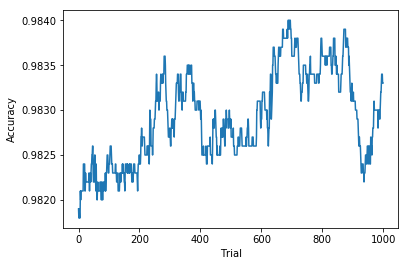

In [35]:
plt.plot(accuracy_log)
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.show()

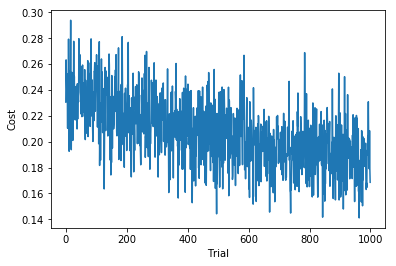

In [36]:
plt.plot(cost_log)
plt.xlabel("Trial")
plt.ylabel("Cost")
plt.show()

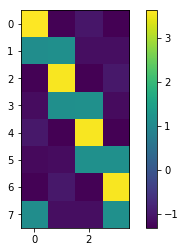

[[ 3.62439322 -1.29397428 -1.01684737 -1.31357646]
 [ 1.10685706  1.15459597 -1.13052809 -1.13092399]
 [-1.2913121   3.58194661 -1.29857111 -0.99207073]
 [-1.15618336  1.15451574  1.16342342 -1.16175485]
 [-0.98663539 -1.29496408  3.57766485 -1.29606199]
 [-1.18021202 -1.14035022  1.15602815  1.1645335 ]
 [-1.29098237 -0.99377006 -1.2931459   3.57789946]
 [ 1.10565567 -1.13537979 -1.12751615  1.15724266]]


In [37]:
plt.imshow(W.eval())
plt.colorbar()
plt.show()
print(W.eval())

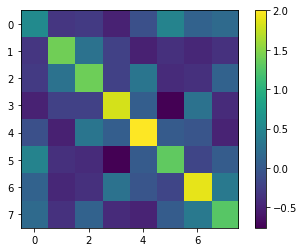

[[ 0.56424195 -0.3263678  -0.29194242 -0.49847141 -0.08586273  0.47752902
   0.1104536   0.19731812]
 [-0.3263678   1.39942145  0.27585143 -0.22615524 -0.51303053 -0.37942043
  -0.45451909 -0.36268285]
 [-0.29194242  0.27585143  1.38782179 -0.22935663  0.30753461 -0.42032579
  -0.37382203  0.1019727 ]
 [-0.49847141 -0.22615524 -0.22935663  1.81859708  0.05897367 -0.76154178
   0.28051674 -0.42614272]
 [-0.08586273 -0.51303053  0.30753461  0.05897367  2.00166392  0.03644772
  -0.0342291  -0.48675457]
 [ 0.47752902 -0.37942043 -0.42032579 -0.76154178  0.03644772  1.32687569
  -0.17981705  0.04684832]
 [ 0.1104536  -0.45451909 -0.37382203  0.28051674 -0.0342291  -0.17981705
   1.89668059  0.3588973 ]
 [ 0.19731812 -0.36268285  0.1019727  -0.42614272 -0.48675457  0.04684832
   0.3588973   1.28731692]]


In [38]:
plt.imshow(cov_normalized.eval())
plt.colorbar()
plt.show()
print(cov_normalized.eval())

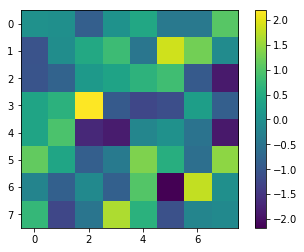

[[ 0.0333939  -0.00385402 -0.8530395   0.05548302  0.4471719  -0.40433735
  -0.41214159  1.05696368]
 [-1.06574392 -0.03860862  0.45971972  0.82680738 -0.45769292  1.87140727
   1.27079666 -0.06214056]
 [-1.03992867 -0.79067516  0.16789043  0.35852793  0.64006406  0.85427523
  -0.93588835 -1.86290896]
 [ 0.37185648  0.63594103  2.19296384 -0.93250877 -1.24182832 -1.13343155
   0.27718708 -0.84980857]
 [ 0.37880021  0.95476091 -1.67897189 -1.84213686 -0.17186756  0.0244489
  -0.50776875 -1.87967014]
 [ 1.13954461  0.39549366 -0.85609603 -0.3744432   1.34102154  0.56304157
  -0.57883704  1.45221078]
 [-0.19949508 -0.83241707 -0.10920069 -0.83400613  1.03063738 -2.17865062
   1.78562093 -0.00591063]
 [ 0.7359193  -1.24043858 -0.48211515  1.65698767  0.61118209 -1.09525394
  -0.19147626 -0.10210134]]


In [24]:
plt.imshow(A.eval())
plt.colorbar()
plt.show()
print(A.eval())

In [ ]:
print(noise_log_det.eval())

In [25]:
dim1 = 0
dim2 = 2
covar = cov_normalized.eval()
[lambda_eigen, v_eigen] = np.linalg.eig(covar[3:5,3:5])

In [26]:
v_eigen

array([[-0.95507789, -0.29635495],
       [ 0.29635495, -0.95507789]], dtype=float32)

In [27]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [28]:
lambda_max = np.amax(lambda_eigen)
l_max_idx = np.where(lambda_eigen==lambda_max)[0][0]
v_max = v_eigen[:,l_max_idx]
[rho_max,phi_max] = cart2pol(v_max[0],v_max[1])
lambda_min = np.amin(lambda_eigen)
l_min_idx = np.where(lambda_eigen==lambda_min)[0][0]
v_min = v_eigen[:,l_min_idx]
[rho_min,phi_min] = cart2pol(v_min[0],v_min[1])

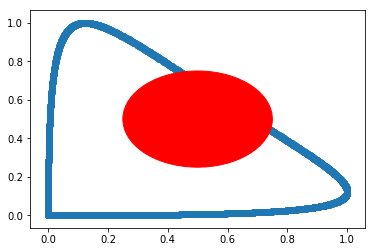

In [30]:
ax = plt.gca()
plt.scatter(test_feat[:,3],test_feat[:,4])

ellipse =Ellipse([0.5,0.5],width=rho_min/2,height=rho_max/2,angle=phi_max,color = 'r')
ax.add_patch(ellipse)
plt.show()

In [ ]:
test_feat[:,0]

In [ ]:
# correct solution:
def softmax(z):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [ ]:
W_trained = W.eval()
b_trained = b.eval()
A_ev = A.eval()
snr_ev = noise_scale.eval()


In [ ]:
cov_ev = 1 * np.eye(num_features) + np.dot(A_ev, A_ev.T)
cov_normalized_ev = cov_ev/pow(np.linalg.det(cov_ev), 1./num_features)
L_ev = np.linalg.cholesky(cov_normalized_ev)
noise_ev = np.dot(eps_test, L_ev.T)
snr_ev = 10.
y_test = (np.dot(snr_ev*test_feat + noise_ev, W_trained) + b_trained)
y_sf = softmax(y_test)

In [ ]:
#print(y_sf)
print(degs_test)
#print(labels_test)

In [ ]:
print(b_trained)

In [ ]:
N_test = 270
degs_test = 0+ 10*(np.random.rand(N_test, 1)-0.5)
test_feat = np.zeros((N_test, num_features)) #tuning curve values
labels_test = np.zeros_like(test_feat)
for i in range(N_test):
    # allow wrapping:
    x_val = degs_test[i]
    if abs(x_val-0) < abs(x_val-360):
        x_tune_0 = get_gaussian_tuning(x_val,0,sigma)
    else:
        x_tune_0 = get_gaussian_tuning(x_val,360,sigma)    
    # get value for each tuning curve/unit
    test_feat[i,0] = x_tune_0
    test_feat[i,1] = get_gaussian_tuning(x_val,90,sigma)
    test_feat[i,2] = get_gaussian_tuning(x_val,180,sigma)
    test_feat[i,3] = get_gaussian_tuning(x_val,270,sigma) 
    test_feat_max = np.amax(test_feat[i,:])
    max_ind = np.where(test_feat[i,:] == test_feat_max)[0][0]
    labels_test[i,max_ind] = 1
eps_test = np.random.normal(size = (N_test, num_features),scale = 0.1)